# 1.1 Two-phase flow model

The water-oil displacement in a petroleum reservoir can be approximated
with the Buckley-Leverett (BL) model. The two-phase transport in a porous medium using the BL model can be described by **Equation 1**.

**Eq. 1**

\begin{equation}
\frac{\partial S_{w}}{\partial t}+\frac{q}{\varphi a} \frac{\partial}{\partial x}(f)=0, \text { in } \Omega \times[0, T]
\end{equation}

where

- **q** - total influx,

- **a** - core sample cross section area,

- **𝜑** - matrix porosity


\begin{equation}
S_{w}=S_{w}(x, t) \text {-denotes the water saturation}
\end{equation}

- **𝑓** - fractional flow function

**Eq. 2** 

\begin{equation}
f=\frac{\boldsymbol{\kappa}_{r w}}{\boldsymbol{\kappa}_{r w}+\left(\frac{\mu_{w}}{\mu_{o}}\right) \boldsymbol{\kappa}_{r o}}
\end{equation}

where

\begin{equation}
\kappa_{r w}=\kappa_{r w}\left(S_{w}\right) \text { и } \kappa_{r o}=\kappa_{r o}\left(S_{w}\right) \text { - the water and oil phase relative permeabilities, respectively}
\end{equation}


\begin{equation}
\mu_{w} \text { , } \mu_{o} \text {- water and oil viscosities, respectively}
\end{equation} 

### initial conditions:

**Eq. 3**
\begin{equation}
S_{w}(x, 0)=S_{w 0}
\end{equation}

### boundary conditions:

**Eq. 4**
\begin{equation}
S_{w}(0, t)=1.0-S_{o 0}
\end{equation}

the maximum of water is injected at a constant flow rate of **q**

In [ ]:
## Google Colab ations 
#!pip install salib
#!pip install tqdm
#!git clone https://github.com/ABAZH666/project_uq_and_sa.git
#%cd project_uq_and_sa/


In [197]:
# The initial code was provided by sonny-qa 
# LINK [https://github.com/sonny-qa/buckley-leverett/blob/master/buckley-lev.ipynb]
import numpy as np
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import tqdm
import math

import warnings


In [198]:
warnings.filterwarnings('ignore')

In [62]:
class BuckleyLev():
    
    def __init__(self, porosity, viscosity_w, viscosity_o, diam, length, rate, initial_sw, residual_o, residual_w, kroe, krwe):
        self.params = {
            #OIL phase viscosity /// our case 𝜇o (non wetting phase)
            "viscosity_o": viscosity_o,
            
            #WATER phase viscosity /// our case 𝜇𝑤 (wetting phase)
            "viscosity_w": viscosity_w,
            
            #initial water sat /// our case Sw, in the initial conditions Sw=Sw0
            "initial_sw":initial_sw,
            
            #residual water saturation, Swirr (irreducible) /// our case 𝑆w0  - connate water saturation 
            "residual_w":residual_w,
            
            #residual oil saturation, Sor /// our case 𝑆𝑜0
            "residual_o": residual_o,
            
            #water rel perm at water curve end point
            "krwe":krwe,
            
            #oil rel perm at oil curve end point
            "kroe": kroe,
            
            #dimless velocity results
            'vd_array':[],
            
            #porosity
            'poro':porosity,
            
            #water injection rate units TBD
            "inject_rate":rate,
            
            #cross sectional area units TBD
            "x-area": ((diam * 1.)/2 **2) * math.pi * length
        }
        
    def k_rw(self,sw):
        #water relative perm calculation for a given water saturation 
        p = self.params["inject_rate"]
        return ((self.params['krwe']))*sw**p
    
    def k_rn(self,sw):
        #oil relative perm calculation for a given water saturation 
        q = self.params["inject_rate"]
        return ((1.-self.params['kroe']*sw)**q)
    
    def fractional_flow(self,sw):
        #returns the fractional flow

        return 1./(1.+((self.k_rn(sw)/self.k_rw(sw))*(self.params["viscosity_w"]/self.params["viscosity_o"])))
    
    def fractional_flow_deriv(self,sw):
        #calculate derivative of fractional flow - dFw/dSw - Vsh

        f_deriv = (self.fractional_flow(sw+0.0001) - self.fractional_flow(sw))/0.0001

        return f_deriv
    
    def fractional_flow_2deriv(self,sw):
        f_2deriv = ((self.fractional_flow(sw+0.01))-2*(self.fractional_flow(sw))-self.fractional_flow(sw-0.01))/((0.01)**2)
        return f_2deriv
    
    def plot_fractional_flow_deriv(self, y):
        #plot the derivative dFw/dSw - Vsh vs Sw
        #y = np.linspace(self.params["residual_w"]+1e-3,(1-self.params["residual_o"]+1e-3),50)
        x = [self.fractional_flow_deriv(i) for i in y ]

        plt.plot(x,y)
        plt.title('Derivative of fractional flow curve')
        plt.xlabel('dfw/dSw')
        plt.ylabel('Sw')
        plt.show()
        
        
    def sw_at_shock_front(self, y): 
        #first find range to search in by looking where 2nd derivative is negative (where curve turns)

        #sw_start = 1.-self.params['residual_o']
        #sw_end = self.params['residual_w']


        #for sw in np.arange(self.params['residual_w']+1.e-9, 1.-self.params['residual_o'],0.001):
        for sw in y:
            if (self.fractional_flow_2deriv(sw)< -1.e-2 and sw < y[0]):
                #i.e. we are below sw_start and the grad is negative - update upper limit
                sw_start = sw
            if (self.fractional_flow_2deriv(sw)< -1.e-2 and sw > y[-1]):
                # i.e. we are above sw_end and the gradient is negative - update lower limit
                sw_end = sw


        sw_at_front = 0.
        current_min = 1000.

        #find where finite difference approximation (almost) equals the continuous value of the function
        #for sw in np.arange(sw_start,sw_end, 0.0001):
        for sw in y:

            current_diff = abs(self.fractional_flow_deriv(sw)-self.fractional_flow(sw)/sw)
            #print( 'grad func',self.fractional_flow_deriv(sw),sw,self.fractional_flow(sw)/sw)
            #print('approx',self.fractional_flow(sw)/sw, sw)
            if current_diff < current_min:
                #print('sw at front',current_min, sw,current_diff)
                current_min = current_diff
                sw_at_front = sw

                current_min = current_diff

        return sw_at_front

    def plot_fractional_flow(self, x):
        #plot the sw vs fractional flow

        #x = np.linspace(self.params["residual_w"]+1e-3,(1-self.params["residual_o"]+1e-3),100)
        #x = np.linspace(self.params["residual_w"]+1e-3,(1),100)
        y = [self.fractional_flow(i) for i in x ]

        plt.plot(x,y)

        #sw_at_front = self.sw_at_shock_front()
        #plt.plot([sw_at_front],[self.fractional_flow(sw_at_front)],'ro')

        plt.title('Fractional flow as a function of water saturation')
        plt.xlabel('Sw')
        plt.ylabel('Fractional flow')
        #plt.ylim([0,0.5])
        plt.xlim([0,1])

        #add limiting fractional flow lines
        plt.hlines(y[len(y)-1],0,1,linestyles='dashed',lw=2, colors='0.4')
        plt.annotate('fw max: %.4f' % y[len(y)-1],xy=(0.08,0.95))


        plt.show()
        #print(y[len(y)-1])
        
        
    def displacement_plot(self, y):
        #using the shock front velocity, plot the displacement profile
        v_sh = self.sw_at_shock_front(y)

        #y = np.linspace(self.params["residual_w"]+1e-3,(1-self.params["residual_o"]+1e-3),50)
        x = [self.fractional_flow_deriv(i) for i in y if self.fractional_flow_deriv(i)>v_sh ]


        return x 
    
    def rarefaction_plot(self, x):
        # it should calculate the shock velocity and the corresponding saturation which this occurs an

        #create dx window of increasing size for calculating welge
        #x = np.linspace(self.params["residual_w"]+1e-3,(1-self.params["residual_o"]+1e-3),50)

        maximum, sw_shock = 0,0
        grads = []

        # to do - add flag to allow BL_time function to calcuate sw values from supplied Xd values
        ## calculate welge gradient at each point until we find the max = shock velocity

        for swi in x:
            grad = self.fractional_flow(swi)/(swi-self.params["residual_w"]+1e-3)
            # vd = xd/td
            grads.append(grad)

            if grad>maximum:
                sw_shock = swi
                maximum = grad

        #find the position of the shock velocity in the grads array and slice to this point for the rarefaction 
        #plus one to include the actual shock velocity. Reverse to get the values in the right order
        rarefaction = (grads[:([i for i,j in enumerate(grads) if j == maximum][0]+1)])
        rarefaction.sort(reverse=True)

        y = x[:(len(rarefaction))]

        #save calculated grads to instance 
        print(rarefaction[0], rarefaction, y)
        for v in rarefaction:
            self.params['vd_array'].append(v)

        #plot rarefaction part 
        plt.plot(rarefaction,y,'b',lw=2)

        #highlight vshock point
        #plt.plot(rarefaction[0],y[0],'ro')
        plt.plot(rarefaction[1],y[1],'ro')

        #add the part ahead of the shock front
        plt.vlines(rarefaction[0],y[0],self.params["initial_sw"],'b',lw=2)
        plt.hlines(self.params["initial_sw"],rarefaction[0],rarefaction[0]+1,'b',lw=2)

        #add saturation lines
        #plt.hlines(self.params["initial_sw"],0,rarefaction[0],linestyles='dashed',lw=2,colors='0.4')
        plt.hlines(y[1],0,rarefaction[1],linestyles='dashed',lw=2,colors='0.4')
        plt.hlines(y[0],0,rarefaction[0],linestyles='dashed',lw=2, colors='0.4')
        plt.vlines(rarefaction[0],-2,self.params["initial_sw"],linestyles='dashed',lw=2, colors='0.4')

        # add annotations
        plt.annotate('V shock',xy=(rarefaction[0]+0.02,y[0]+0.02))
        plt.annotate('Sw f',xy=(0+0.04,y[0]-0.05))
        plt.annotate('Sw i',xy=(0+0.04,y[1]-0.05))#self.params["initial_sw"]-0.05))


        #ad vdmin if the min velocity values is not zero 
        if (rarefaction[len(rarefaction)-1]>0.e-22):
            plt.hlines(y[len(y)-1],0,rarefaction[len(rarefaction)-1],'b',lw=2)
            plt.plot(rarefaction[len(rarefaction)-1],y[len(y)-1],'ro')
            plt.annotate('V min',xy=((rarefaction[len(rarefaction)-1]+0.08),(y[len(y)-1])))
            plt.vlines(rarefaction[len(rarefaction)-1],y[len(y)-1],0,linestyles='dashed',lw=2, colors='0.4')
            plt.annotate('Sw c',xy=(0+0.04,1-self.params["residual_o"]+0.03))

        plt.xlabel('Dimensionless Velocity, Vd = xd/td')
        plt.ylabel('Saturation')

        plt.ylim([0,1])
        plt.xlim([-0.1,rarefaction[0]+1])
        plt.title('Saturation profile velocity')
        plt.show()


# Cherie

In [63]:
class Cherie():
    
    def __init__(self , initial_sw, residual_w, residual_o, krwe, kroe, viscosity_o, viscosity_w):
        self.B = 1.
        self.M = 1.
        self.A = 1.
        self.L = 1.
        self.params = {
 
            #initial water sat /// our case Sw, in the initial conditions Sw=Sw0
            "initial_sw":initial_sw,
            
            #residual water saturation, Swirr (irreducible) /// our case 𝑆w0  - connate water saturation 
            "residual_w":residual_w,
            
            #residual oil saturation, Sor /// our case 𝑆𝑜0
            "residual_o": residual_o,
            
            #water rel perm at water curve end point
            "krwe":krwe,
            
            #oil rel perm at oil curve end point
            "kroe": kroe,
            
            #OIL phase viscosity /// our case 𝜇o (non wetting phase)
            "viscosity_o": viscosity_o,
            
            #WATER phase viscosity /// our case 𝜇𝑤 (wetting phase)
            "viscosity_w": viscosity_w,

        }
        
                 
    def calc_krw(self, sw):
        return self.params['krwe']*math.e**(-self.B*(((sw-self.params['residual_w']+0.00001)/(1-sw-self.params['residual_o']))**(-self.M)))
                                            
    def calc_kro(self, sw):
        return self.params['kroe']*math.e**(-self.A*(((sw-self.params['residual_w']+0.00001)/(1-sw-self.params['residual_o']))**(-self.L)))
                                                                                                                            
                 
    def fractional_flow(self,sw):
        #returns the fractional flow
        return self.calc_krw(sw)/(self.calc_krw(sw)+(self.params['viscosity_w'] / self.params['viscosity_o'])*self.calc_kro(sw)+0.0001)
        #return 1./(1.+((self.k_rn(sw)/self.k_rw(sw))*(self.params["viscosity_w"]/self.params["viscosity_o"])))          
        
        
    def plot_fractional_flow(self, x):
        #plot the sw vs fractional flow

        #x = np.linspace(self.params["residual_w"]+1e-3,(1-self.params["residual_o"]+1e-3),100)
        #x = np.linspace(self.params["residual_w"]+1e-3,(1),100)
        y = [self.fractional_flow(i) for i in x ]

        plt.plot(x,y)

        #sw_at_front = self.sw_at_shock_front()
        #plt.plot([sw_at_front],[self.fractional_flow(sw_at_front)],'ro')

        plt.title('Fractional flow as a function of water saturation')
        plt.xlabel('Sw')
        plt.ylabel('Fractional flow')
        #plt.ylim([0,0.5])
        plt.xlim([0,1])

        #add limiting fractional flow lines
        plt.hlines(y[len(y)-1],0,1,linestyles='dashed',lw=2, colors='0.4')
        plt.annotate('fw max: %.4f' % y[len(y)-1],xy=(0.08,0.95))


        plt.show()
        #print(y[len(y)-1])
        
        

    def rarefaction_plot(self, x):
        # it should calculate the shock velocity and the corresponding saturation which this occurs an

        #create dx window of increasing size for calculating welge
        #x = np.linspace(self.params["residual_w"]+1e-3,(1-self.params["residual_o"]+1e-3),50)

        maximum, sw_shock = 0,0
        grads = []

        # to do - add flag to allow BL_time function to calcuate sw values from supplied Xd values
        ## calculate welge gradient at each point until we find the max = shock velocity

        for swi in x:
            grad = self.fractional_flow(swi)/(swi-self.params["residual_w"]+1e-3)
            # vd = xd/td
            grads.append(grad.real)
            #print(self.fractional_flow(swi), swi-self.params["residual_w"]+1e-3,  grad)

            if grad.real>maximum:
                sw_shock = swi
                maximum = grad.real
        #print(grads)
        #find the position of the shock velocity in the grads array and slice to this point for the rarefaction 
        #plus one to include the actual shock velocity. Reverse to get the values in the right order
        #rarefaction = (grads[:([i for i,j in enumerate(grads) if j == maximum][0]+1)])
        #rarefaction = (grads[:([i for i,j in enumerate(grads)][0]+1)])
        rarefaction=grads
        rarefaction.sort(reverse=True)

        y = x[:(len(rarefaction))]
        #print(y)
        #print(rarefaction)

        #save calculated grads to instance 
        #print(rarefaction[0], rarefaction, y)
        #for v in rarefaction:
        #    self.params['vd_array'].append(v)

        #plot rarefaction part 
        plt.plot(rarefaction,y,'b',lw=2)

        #highlight vshock point
        #plt.plot(rarefaction[0],y[0],'ro')
        plt.plot(rarefaction[5],y[5],'ro')

        #add the part ahead of the shock front
        plt.vlines(rarefaction[0],y[0],self.params["initial_sw"],'b',lw=2)
        plt.hlines(self.params["initial_sw"],rarefaction[0],rarefaction[0]+1,'b',lw=2)

        #add saturation lines
        #plt.hlines(self.params["initial_sw"],0,rarefaction[0],linestyles='dashed',lw=2,colors='0.4')
        plt.hlines(y[5],0,rarefaction[5],linestyles='dashed',lw=2,colors='0.4')
        plt.hlines(y[0],0,rarefaction[0],linestyles='dashed',lw=2, colors='0.4')
        plt.vlines(rarefaction[0],-2,self.params["initial_sw"],linestyles='dashed',lw=2, colors='0.4')

        # add annotations
        plt.annotate('V shock',xy=(rarefaction[5]+0.02,y[5]+0.02))
        plt.annotate('Sw f',xy=(0+0.04,y[0]-0.05))
        plt.annotate('Sw i',xy=(0+0.04,y[1]-0.05))#self.params["initial_sw"]-0.05))


        #ad vdmin if the min velocity values is not zero 
        if (rarefaction[len(rarefaction)-1]>0.e-22):
            plt.hlines(y[len(y)-1],0,rarefaction[len(rarefaction)-1],'b',lw=2)
            plt.plot(rarefaction[len(rarefaction)-1],y[len(y)-1],'ro')
            plt.annotate('V min',xy=((rarefaction[len(rarefaction)-1]+0.08),(y[len(y)-1])))
            plt.vlines(rarefaction[len(rarefaction)-1],y[len(y)-1],0,linestyles='dashed',lw=2, colors='0.4')
            plt.annotate('Sw c',xy=(0+0.04,1-self.params["residual_o"]+0.03))

        plt.xlabel('Dimensionless Velocity, Vd = xd/td')
        plt.ylabel('Saturation')

        plt.ylim([0,1])
        plt.xlim([0,rarefaction[0]+1])
        plt.title('Saturation profile velocity')
        plt.show()
        
    def sobol_target_function(self, x):
        # it should calculate the shock velocity and the corresponding saturation which this occurs an

        #create dx window of increasing size for calculating welge
        #x = np.linspace(self.params["residual_w"]+1e-3,(1-self.params["residual_o"]+1e-3),50)

        maximum, sw_shock = 0,0
        grads = []

        # to do - add flag to allow BL_time function to calcuate sw values from supplied Xd values
        ## calculate welge gradient at each point until we find the max = shock velocity

        for swi in x:
            grad = self.fractional_flow(swi)/(swi-self.params["residual_w"]+1e-3)
            grads.append(grad.real)

            if grad.real>maximum:
                sw_shock = swi
                maximum = grad.real

        rarefaction=grads
        rarefaction.sort(reverse=True)

        y = x[:(len(rarefaction))]
        return rarefaction[5], y[5]


In [64]:
qi1 = pd.read_excel("./datasets/dataset1.xlsx")
swlist1=list(qi1['Sw'])
krw1=list(qi1['Krw'])
kro1=list(qi1['Kro'])

In [65]:
ch2=Cherie(
                viscosity_w = 0.306, 
                viscosity_o = 0.670, 
                initial_sw = 0.2, 
                residual_o = 0.26, 
                residual_w = 0.2, 
                kroe = 0.95, 
                krwe = 0.3)

In [66]:
qi2 = pd.read_excel("./datasets/dataset2.xlsx")
swlist2=list(qi2['Sw'])
krw2=list(qi2['Krw'])
kro2=list(qi2['Kro'])

In [67]:
ch1=Cherie(
                viscosity_w = 0.65, 
                viscosity_o = 1.25, 

                initial_sw = 0.15, 
                residual_o = 0.35, 
                residual_w = 0.15, 
                kroe = 0.65, 
                krwe = 0.25)

In [68]:
ch1.fractional_flow(swlist1[0])

0.17897393575103684

In [69]:
#вместо mcmc используется gridsearch + SALib library

In [70]:
def get_error(ch, swlist, kro, krw):
    cur_error=0
    for i in range(len(swlist)):
        cur_krw = ch.calc_krw(swlist[i])
        cur_kro = ch.calc_kro(swlist[i])
        cur_error += np.abs(kro[i]-cur_kro)**2+np.abs(krw[i]-cur_krw)**2
    return cur_error


def find_params(ch, swlist, kro, krw, al, ar, ll, lr, bl, br, ml, mr):
    glob_error=10**10
    glob_params=[-1, -1, -1, -1]

    for A in range(al, ar):
        ch.A=A/100
        for L in range(ll , lr):
            ch.L=L/100
            for B in range(bl, br):
                ch.B=B/100
                for M in range(ml, mr):
                    ch.M=M/100
                    cur_error = get_error(ch, swlist, kro, krw)
                    if cur_error < glob_error:
                        glob_error = cur_error
                        glob_params = [ch.A, ch.L, ch.B, ch.M]

    print(glob_error, glob_params)
    return glob_params

In [71]:
ch1.A, ch1.L, ch1.B, ch1.M=find_params(ch1,  swlist1, kro1, krw1,\
                                       147, 159, 60, 68, 283, 296, 64, 72)

9.84548795563146 [1.47, 0.6, 2.83, 0.71]


In [72]:
#ch1.plot_fractional_flow(swlist1)

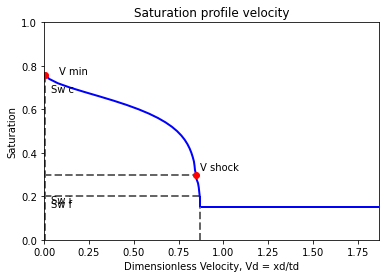

In [73]:
ch1.rarefaction_plot(swlist1)

In [74]:
ch2.A, ch2.L, ch2.B, ch2.M=find_params(ch2,  swlist2, kro2, krw2, 191, 206, 42, 49, 186, 204, 80, 97)

234478257.7869995 [2.03, 0.47, 1.86, 0.8]


In [75]:
#ch2.plot_fractional_flow(swlist2)

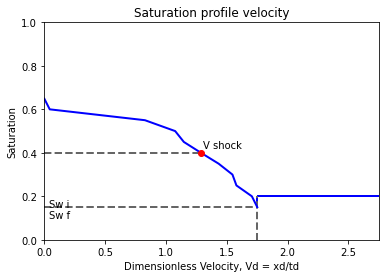

In [76]:
ch2.rarefaction_plot(swlist2)

# LET

In [77]:
class LET():
    
    def __init__(self , initial_sw, residual_w, residual_o, krwe, kroe, viscosity_o, viscosity_w):
        self.Lw = 1.
        self.Lo = 1.
        self.Ew = 1.
        self.Eo = 1.
        self.Tw = 1.
        self.To = 1.
        self.params = {
 
            #initial water sat /// our case Sw, in the initial conditions Sw=Sw0
            "initial_sw":initial_sw,
            
            #residual water saturation, Swirr (irreducible) /// our case 𝑆w0  - connate water saturation 
            "residual_w":residual_w,
            
            #residual oil saturation, Sor /// our case 𝑆𝑜0
            "residual_o": residual_o,
            
            #water rel perm at water curve end point
            "krwe":krwe,
            
            #oil rel perm at oil curve end point
            "kroe": kroe,
            
            #OIL phase viscosity /// our case 𝜇o (non wetting phase)
            "viscosity_o": viscosity_o,
            
            #WATER phase viscosity /// our case 𝜇𝑤 (wetting phase)
            "viscosity_w": viscosity_w,

        }
        
                 
    def calc_krw(self, sw):
        #effective water saturation
        Swe = (sw-self.params['residual_w'])/(1-sw-self.params['residual_o'])
        return self.params['krwe']*((Swe**self.Lw)/(Swe**self.Lw + self.Ew*((1 - Swe)**self.Tw)))
        
                                            
    def calc_kro(self, sw):
        Swe = (sw-self.params['residual_w'])/(1-sw-self.params['residual_o'])
        #print(Swe, self.Lo, self.To)
        return self.params['kroe']*((1- Swe)**self.Lo)/(((1 - Swe)**self.Lo)+self.Eo*(Swe**self.To))
                                                                                                                                    
                 
    def fractional_flow(self,sw):
        #returns the fractional flow
        return self.calc_krw(sw)/(self.calc_krw(sw)+(self.params['viscosity_w'] / self.params['viscosity_o'])*self.calc_kro(sw)+0.0001)
        #return 1./(1.+((self.k_rn(sw)/self.k_rw(sw))*(self.params["viscosity_w"]/self.params["viscosity_o"])))          
        
        
    def plot_fractional_flow(self, x):
        #plot the sw vs fractional flow

        #x = np.linspace(self.params["residual_w"]+1e-3,(1-self.params["residual_o"]+1e-3),100)
        #x = np.linspace(self.params["residual_w"]+1e-3,(1),100)
        y = [self.fractional_flow(i) for i in x ]

        plt.plot(x,y)

        #sw_at_front = self.sw_at_shock_front()
        #plt.plot([sw_at_front],[self.fractional_flow(sw_at_front)],'ro')

        plt.title('Fractional flow as a function of water saturation')
        plt.xlabel('Sw')
        plt.ylabel('Fractional flow')
        #plt.ylim([0,0.5])
        plt.xlim([0,1])

        #add limiting fractional flow lines
        plt.hlines(y[len(y)-1],0,1,linestyles='dashed',lw=2, colors='0.4')
        plt.annotate('fw max: %.4f' % y[len(y)-1],xy=(0.08,0.95))


        plt.show()
        #print(y[len(y)-1])
        
        

    def rarefaction_plot(self, x):
        # it should calculate the shock velocity and the corresponding saturation which this occurs an

        #create dx window of increasing size for calculating welge
        #x = np.linspace(self.params["residual_w"]+1e-3,(1-self.params["residual_o"]+1e-3),50)

        maximum, sw_shock = 0,0
        grads = []

        # to do - add flag to allow BL_time function to calcuate sw values from supplied Xd values
        ## calculate welge gradient at each point until we find the max = shock velocity

        for swi in x:
            grad = self.fractional_flow(swi)/(swi-self.params["residual_w"]+1e-3)
            # vd = xd/td
            grads.append(grad.real)
            #print(self.fractional_flow(swi), swi-self.params["residual_w"]+1e-3,  grad)

            if grad.real>maximum:
                sw_shock = swi
                maximum = grad.real
        #print(grads)
        #find the position of the shock velocity in the grads array and slice to this point for the rarefaction 
        #plus one to include the actual shock velocity. Reverse to get the values in the right order
        #rarefaction = (grads[:([i for i,j in enumerate(grads) if j == maximum][0]+1)])
        #rarefaction = (grads[:([i for i,j in enumerate(grads)][0]+1)])
        rarefaction=grads
        rarefaction.sort(reverse=True)

        y = x[:(len(rarefaction))]
        #print(y)
        #print(rarefaction)

        #save calculated grads to instance 
        #print(rarefaction[0], rarefaction, y)
        #for v in rarefaction:
        #    self.params['vd_array'].append(v)

        #plot rarefaction part 
        plt.plot(rarefaction,y,'b',lw=2)

        #highlight vshock point
        #plt.plot(rarefaction[0],y[0],'ro')
        plt.plot(rarefaction[1],y[1],'ro')

        #add the part ahead of the shock front
        plt.vlines(rarefaction[0],y[0],self.params["initial_sw"],'b',lw=2)
        plt.hlines(self.params["initial_sw"],rarefaction[0],rarefaction[0]+1,'b',lw=2)

        #add saturation lines
        #plt.hlines(self.params["initial_sw"],0,rarefaction[0],linestyles='dashed',lw=2,colors='0.4')
        plt.hlines(y[5],0,rarefaction[5],linestyles='dashed',lw=2,colors='0.4')
        plt.hlines(y[0],0,rarefaction[0],linestyles='dashed',lw=2, colors='0.4')
        plt.vlines(rarefaction[0],-2,self.params["initial_sw"],linestyles='dashed',lw=2, colors='0.4')

        # add annotations
        plt.annotate('V shock',xy=(rarefaction[1]+0.02,y[1]+0.02))
        plt.annotate('Sw f',xy=(0+0.04,y[0]-0.05))
        plt.annotate('Sw i',xy=(0+0.04,y[1]-0.05))#self.params["initial_sw"]-0.05))


        #ad vdmin if the min velocity values is not zero 
        if (rarefaction[len(rarefaction)-1]>0.e-22):
            plt.hlines(y[len(y)-1],0,rarefaction[len(rarefaction)-1],'b',lw=2)
            plt.plot(rarefaction[len(rarefaction)-1],y[len(y)-1],'ro')
            plt.annotate('V min',xy=((rarefaction[len(rarefaction)-1]+0.08),(y[len(y)-1])))
            plt.vlines(rarefaction[len(rarefaction)-1],y[len(y)-1],0,linestyles='dashed',lw=2, colors='0.4')
            plt.annotate('Sw c',xy=(0+0.04,1-self.params["residual_o"]+0.03))

        plt.xlabel('Dimensionless Velocity, Vd = xd/td')
        plt.ylabel('Saturation')

        plt.ylim([0,1])
        plt.xlim([0,rarefaction[0]+1])
        plt.title('Saturation profile velocity')
        plt.show()
        
    def sobol_target_function(self, x ):
        # it should calculate the shock velocity and the corresponding saturation which this occurs an

        #create dx window of increasing size for calculating welge
        #x = np.linspace(self.params["residual_w"]+1e-3,(1-self.params["residual_o"]+1e-3),50)

        maximum, sw_shock = 0,0
        grads = []

        # to do - add flag to allow BL_time function to calcuate sw values from supplied Xd values
        ## calculate welge gradient at each point until we find the max = shock velocity

        for swi in x:
            grad = self.fractional_flow(swi)/(swi-self.params["residual_w"]+1e-3)
            # vd = xd/td
            grads.append(grad.real)

            if grad.real>maximum:
                sw_shock = swi
                maximum = grad.real

        rarefaction=grads
        rarefaction.sort(reverse=True)

        y = x[:(len(rarefaction))]
        
        return rarefaction[1], y[1]


In [78]:
qi1 = pd.read_excel("./datasets/dataset1.xlsx")
swlist1=list(qi1['Sw'])
krw1=list(qi1['Krw'])
kro1=list(qi1['Kro'])

In [79]:
let2=LET(
                viscosity_w = 0.306, 
                viscosity_o = 0.670, 
                initial_sw = 0.2, 
                residual_o = 0.26, 
                residual_w = 0.2, 
                kroe = 0.95, 
                krwe = 0.3)

In [80]:
qi2 = pd.read_excel("./datasets/dataset2.xlsx")
swlist2=list(qi2['Sw'])
krw2=list(qi2['Krw'])
kro2=list(qi2['Kro'])

In [81]:
let1=LET(
                viscosity_w = 0.65, 
                viscosity_o = 1.25, 

                initial_sw = 0.15, 
                residual_o = 0.35, 
                residual_w = 0.15, 
                kroe = 0.65, 
                krwe = 0.25)

In [82]:
let1.fractional_flow(swlist1[0])

0.08460523198754613

In [83]:
#вместо mcmc используется gridsearch 

In [84]:
def get_error(let, swlist, kro, krw):
    cur_error=0
    for i in range(len(swlist)):
        cur_krw = let.calc_krw(swlist[i])
        cur_kro = let.calc_kro(swlist[i])
        cur_error += np.abs(kro[i]-cur_kro)**2+np.abs(krw[i]-cur_krw)**2
    return cur_error

In [85]:
def find_params(let, swlist, kro, krw, lwl, lwr, lol, lor, ewl, ewr, eol,eor, twl, twr, tol, tor, step):
    glob_error=10**10
    glob_params=[-1, -1, -1, -1, -1, -1]
        
    for Lw in range(lwl, lwr, step):
        let.Lw=Lw/100
        for Lo in range(lol, lor, step):
            let.Lo=Lo/100
            for Ew in range(ewl, ewr, step):
                let.Ew=Ew/100
                for Eo in range(eol, eor, step):
                    let.Eo=Eo/100
                    for Tw in range(twl, twr, step):
                        let.Tw=Tw/100
                        for To in range(tol, tor, step):
                            let.To=To/100


                            cur_error = get_error(let, swlist, kro, krw)
                            if cur_error < glob_error:
                                glob_error = cur_error
                                glob_params = \
                                        [let.Lw,
                                        let.Lo,
                                        let.Ew,
                                        let.Eo,
                                        let.Tw,
                                        let.To]

    print(glob_error, glob_params)
    return glob_params

In [86]:
let1.Lw, let1.Lo, let1.Ew,let1.Eo,let1.Tw,let1.To=find_params(let1,  swlist1, kro1, krw1, 282, 362, 98, 136, 232, 621, 643, 1538, 66, 120, 216, 295, 30)

2.916079580522968 [2.82, 0.98, 5.92, 6.43, 0.66, 2.76]


In [87]:
#ch1.plot_fractional_flow(swlist1)

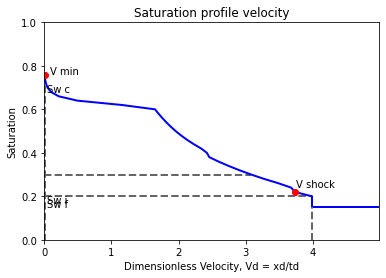

In [88]:
let1.rarefaction_plot(swlist1)

In [89]:
let2.Lw, let2.Lo, let2.Ew,let2.Eo,let2.Tw,let2.To=find_params(let1,  swlist1, kro1, krw1, 334, 457, 120, 172, 24, 143, 310, 778, 1, 105, 66, 133, 30)

4.373321395539807 [3.34, 1.2, 1.14, 3.7, 0.01, 1.26]


In [90]:
#ch2.plot_fractional_flow(swlist2)

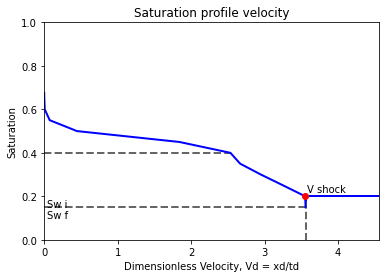

In [91]:
let2.rarefaction_plot(swlist2)

# BL

In [92]:
qi1 = pd.read_excel("./datasets/dataset1.xlsx")
swlist1=list(qi1['Sw'])
krw1=list(qi1['Krw'])
kro1=list(qi1['Kro'])

In [93]:
qi2 = pd.read_excel("./datasets/dataset2.xlsx")
swlist2=list(qi2['Sw'])

In [94]:
#Dataset 2
bl2 = BuckleyLev(
                porosity = 0.2062, 
                viscosity_w = 0.65, 
                viscosity_o = 1.25, 
                diam = 0.05, 
                length = 1.22, 
                rate = 30, 
                initial_sw = 0.15, 
                residual_o = 0.35, 
                residual_w = 0.15, 
                kroe = 0.65, 
                krwe = 0.25
                )

In [95]:
bl1 = BuckleyLev(
                porosity = 0.29, 
                viscosity_w = 0.306, 
                viscosity_o = 0.670, 
                diam = 0.037, 
                length = 0.1174, 
                rate = 5, 
                initial_sw = 0.2, 
                residual_o = 0.26, 
                residual_w = 0.2, 
                kroe = 0.95, 
                krwe = 0.3
                )

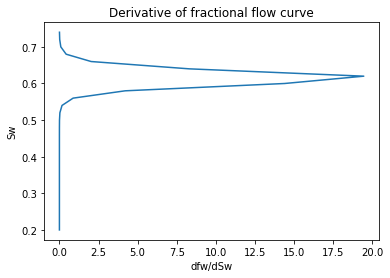

In [97]:
bl2.plot_fractional_flow_deriv(list(qi1['Sw'][:-1]))

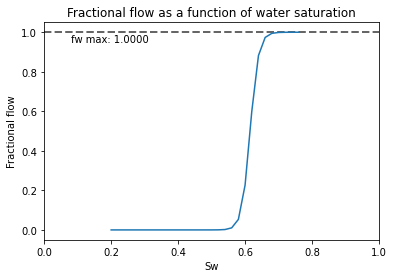

In [99]:
bl2.plot_fractional_flow(swlist1)

In [101]:
bl2.sw_at_shock_front(swlist1)

0.2

2.0045083167382614 [2.0045083167382614, 1.9878892423778265, 1.9364335639151944, 1.8441143299865805, 1.7092906570556534, 1.5367820114194448, 1.338061149092836, 1.1288698146136675, 0.9251797079688894, 0.7395158733252544, 0.6024732726573313, 0.5791820498834908, 0.4465145305973323, 0.34029085616118776, 0.2573328674754279, 0.1937616749146144, 0.14577634298501496, 0.11004524238223616, 0.0838562443935711, 0.06516300499484758, 0.05267915903636464, 0.05200101311155053, 0.04643365731806475] [0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64]


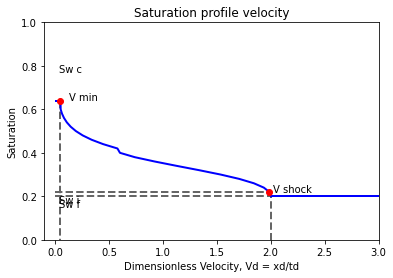

In [102]:
bl1.rarefaction_plot(swlist1)

In [103]:
bl1.sw_at_shock_front(swlist1)

0.2

1.8856842348648535 [1.8856842348648535, 1.8832541726897254, 0.5021915684275587, 0.011259360797561376, 0.00016849647037558282, 2.032132357625103e-06, 1.8497417092839146e-08, 1.158316639698567e-10, 4.392592829556935e-13, 8.438613190821305e-16, 6.602201581829027e-19, 2.0010508244823996e-21] [0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.675]


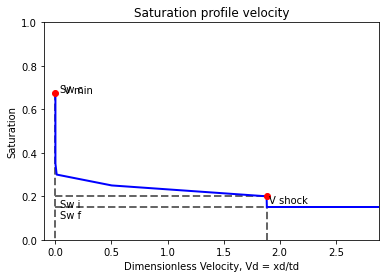

In [104]:
bl2.rarefaction_plot(swlist2)

In [105]:
bl2.sw_at_shock_front(swlist2)

0.15

# 1.2 Relative permeability models

### Two widely used **relative permeability models** were considered for the Buckley-Leverett (Eq. 1): 


###  a) The Chierici’s relative permeability model 

**Eq. 5**
\begin{equation}
\kappa_{r w}=\kappa_{w}^{0} e^{-B\left(\frac{S_{w}-S_{w 0}}{1-S_{w}-S_{o 0}}\right)^{-M}}
\quad \kappa_{r o}=\kappa_{o}^{0} e^{-A\left(\frac{S_{w}-S_{w 0}}{1-S_{w}-S_{o 0}}\right)^{L}}
\end{equation}

where 

- **A**, **L**, **B** and **M** - parameters for the relative permeabilities

###  b) The LET relative permeability model 

**Eq. 6**
\begin{equation}
\kappa_{r w}=\kappa_{w}^{0} \frac{S_{w e}^{L_{w}}}{S_{w e}^{L_{w}}+E_{w}\left(1-S_{w e}\right)^{T_{w}}} \quad \kappa_{r o}=\kappa_{o}^{0} \frac{\left(1-S_{w e}\right)^{L_{o}}}{\left(1-S_{w e}\right)^{L_{o}}+E_{o} S_{w e}^{T_{o}}}
\end{equation}

where 

- **Lw**, **Ew**, **Tw**, **Lo**, **Eo**, and **To** - parameters of the model  (**w** - water phase and **o** - oil phase)

**Swe** - effective water saturation calculated as:

**Eq. 7**

\begin{equation}
S_{w e}=\frac{S_{w}-S_{w 0}}{1-S_{w 0}-S_{o 0}}
\end{equation}

where 

- **Sw0** - connate water saturation, 

- **So0** the residual oil saturation, 

- **𝜅0o** - oil relative permeability at the connate water saturation, 

- **𝜅0𝑤** - water relative permeability at the residual oil saturation

# 1.3 Datasets 

!разобраться откуда какие данные!

# 1.4 Input parameters and quantities of interest

To perform UQ and SA studies we must define a set of input parameters θ and relevant **quantities of interest (QoIs)**:

### a) For Chierici’s model the input parameters:

\begin{equation}
θ_{c}={({B; M; A; L})}
\end{equation}

### b) For LET model the input parameters:

\begin{equation}
θ_{c}={({L_{w},E_{w},T_{w},L_{o},E_{o},T_{o}})}
\end{equation}

### The following **QoIs** were considered in this study: 

**Scpt** - relative permeability crossing point, 

**Eq. 8**

\begin{equation}
\kappa_{r w}\left(S_{c p t}\right)-\kappa_{r o}\left(S_{c p t}\right)=0
\end{equation}

**S𝑓** -shock front saturation,

**Eq. 9**

\begin{equation}
\frac{\partial f\left(S_{f}\right)}{\partial S_{w}}\left(S_{f}-S_{w 0}\right)-f\left(S_{f}\right)=0
\end{equation}


**V(t)** - displaced oil at a fixed time

**Eq. 10**

\begin{equation}
V(t)=a \int_{0}^{t} q\left(1-f\left(S_{w}(L, \tau)\right)\right) d \tau
\end{equation}

where 

- **f(Sw(L,𝜏)** - fractional flow function evaluated at any time instant **τ** and at the position **x=L** which, corresponds to the size of the core sample.

The datasets and the simulations performed in this work focus on core-scale experiments. QoIs used in this work were chosen considering their relevance to both core-scale and field-scale experiments. For instance, the crossing point saturation **Scpt** and the shock front saturation **S𝑓** are essential indicators of the performance for both mature or new reservoirs.

# 1.5 Parameter and distribution estimation

For each relative permeability model (Chierici and LET) we performed a parameter estimation based on the presented datasets using the **Markov Chain Monte Carlo (MCMC) method**. 

**(MCMC implemented in emcee library, implemented in the lmfit package, was used to obtain an initial guess for the relative permeability model parameters required for the MCMC).**

### Assuming θ as the relative permeability model parameters and D as the dataset, MCMC tries to estimate:

**Eq. 11**

\begin{equation}
\mathbb{P}(\boldsymbol{\theta} \mid D)=\frac{\mathbb{P}(\boldsymbol{D} \mid \boldsymbol{\theta}) \mathbb{P}(\boldsymbol{\theta})}{\mathbb{P}(D)}
\end{equation}

where 

- **ℙ(𝜽)** - prior knowledge about the input parameters **θ** - joint probability distribution, 

- **ℙ(𝑫∣𝜽)** - likelihood function, 

- **ℙ(𝐷)** - evidence that the data was generated by this model. 

In **Eq. 11** - likelihood function:

**Eq. 12**

\begin{equation}
\ln (\mathbb{P}(D \mid \boldsymbol{\theta}))=-0.5 \sum_{i}^{N_{d}}\left[\left(\frac{D^{i}-y^{i}(\boldsymbol{\theta})}{\sigma^{i}}\right)^{2}+2 \log \left(\sigma^{i}\right)\right]
\end{equation}

where 

- **Nd** - size of the dataset, 

- **𝜎𝑖** represents the error values, 

- **𝑦𝑖(𝜽)** - entry of the vector representing the relative permeability model evaluated at the sample parameters **θ**.

The MCMC method requires the definition of a prior distribution - **flat prior distributions:**

**Eq. 13**

\begin{equation}
\ln (\mathbb{P}(\boldsymbol{\theta}))=\{\text { 0if all entries of } \boldsymbol{\theta} \in \mathbb{R}>0
\end{equation}

-∞ elsewhere.

# 2.1 Uncertainty quantification

# 3.1 Sensitivity analysis

In [199]:
def estimate_sobol_LET(let, swlist, kro, krw, Lw, Lo, Ew, Eo, Tw, To):
    let.Lw=Lw
    let.Lo=Lo
    let.Ew=Ew
    let.Eo=Eo
    let.Tw=Tw
    let.To=To

    for i in range(len(swlist)):
        cur_krw = let.calc_krw(swlist[i])
        cur_kro = let.calc_kro(swlist[i])

#     bl2.sw_at_shock_front(swlist)
#     x, y = let.rarefaction_plot(swlist)
    x, y = let.sobol_target_function(swlist)
    return (x,y)

In [200]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.plotting.bar import plot as barplot

problem_LET = {
    'num_vars': 6,
    'names': ['Lw', 'Lo', 'Ew', 'Eo', 'Tw', 'To'],
    'bounds': [[3.34, 4.57], 
             [1.20, 1.72], 
             [0.24, 1.43], 
             [3.10, 7.78], 
             [0.01, 1.05], 
             [0.66, 1.33]]
}

param_values_LET = saltelli.sample(problem_LET, 1000)


In [201]:
res_x = []
res_y= []
for z in tqdm.tqdm(range(param_values_LET.shape[0])):
    x, y = estimate_sobol_LET(let1,  swlist1, kro1, krw1, *param_values_LET[z,:])
    res_x.append(x)

In [202]:
Si = sobol.analyze(problem_LET, np.array(res_x))

In [203]:
Si_dict = dict(Si) 
sensitivity_indices = ['S1', 'ST', 'S1_conf', 'ST_conf']
Si_df = pd.DataFrame()
for SI in sensitivity_indices:
    Si_df = Si_df.append(pd.Series(Si_dict[SI]), ignore_index=True)

Si_df = Si_df.T
Si_df.columns = sensitivity_indices
Si_df['Parameters'] =problem_LET['names']
Si_df.set_index('Parameters', inplace=True)
Si_df

,S1,ST,S1_conf,ST_conf
Parameters,,,,
Lw,0.016460,0.043505,0.018543,0.006587
Lo,0.151927,0.194765,0.039795,0.022718
Ew,0.310756,0.381869,0.053734,0.040227
Eo,0.251280,0.311204,0.043966,0.028110
Tw,0.186132,0.247474,0.047750,0.029945
To,0.008843,0.035918,0.016579,0.006223


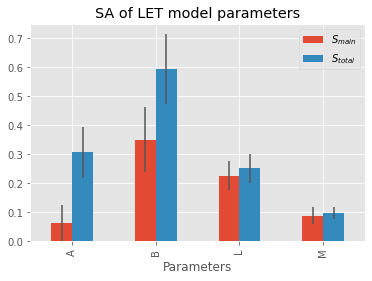

In [225]:
plt.style.use('ggplot')
from SALib.plotting.bar import plot as barplot
barplot(Si_df)
plt.title('SA of LET model parameters')
plt.legend(['$S_{main}$', '$S_{total}$'])
plt.show()

## SA of Chersie model 


In [205]:
def estimate_sobol_CHERSIE(ch, swlist,kro, krw, A, L, B, M):
    ch.A=A
    ch.L=L
    ch.B=B
    ch.M=M

    for i in range(len(swlist)):
        cur_krw = ch.calc_krw(swlist[i])
        cur_kro = ch.calc_kro(swlist[i])

    x, y = ch.sobol_target_function(swlist)
    return (x,y)



In [231]:
problem_Chersie = {
    'num_vars': 4,
    'names': ['A', 'B', 'L', 'M'],
    'bounds': [[1.47, 2.06], 
             [1.86, 2.96], 
             [0.42, 0.68], 
             [0.64, 0.97]]
}


param_values_Chersie = saltelli.sample(problem_Chersie, 10000)

In [234]:
import tqdm

In [236]:
res_x = []
res_y= []
for z in tqdm.tqdm(range(param_values_Chersie.shape[0])):
    x, y = estimate_sobol_CHERSIE(ch1,  swlist1, kro1, krw1, *param_values_Chersie[z,:])
    res_x.append(x)

100%|██████████| 100000/100000 [00:37<00:00, 2699.10it/s]


In [237]:
Si = sobol.analyze(problem_Chersie, np.array(res_x))

In [238]:
Si_dict = dict(Si) 
sensitivity_indices = ['S1', 'ST', 'S1_conf', 'ST_conf']
Si_df = pd.DataFrame()
for SI in sensitivity_indices:
    Si_df = Si_df.append(pd.Series(Si_dict[SI]), ignore_index=True)

Si_df = Si_df.T
Si_df.columns = sensitivity_indices
Si_df['Parameters'] =problem_Chersie['names']
Si_df.set_index('Parameters', inplace=True)
Si_df
# Si_df.to_excel()

,S1,ST,S1_conf,ST_conf
Parameters,,,,
A,0.076036,0.314274,0.016861,0.028607
B,0.349778,0.595866,0.034394,0.041734
L,0.235089,0.258976,0.016202,0.014685
M,0.085365,0.098098,0.007766,0.006036


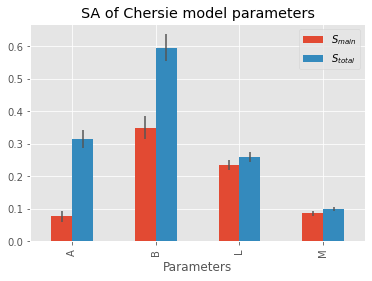

In [240]:

plt.style.use('ggplot')
from SALib.plotting.bar import plot as barplot
barplot(Si_df)
plt.title('SA of Chersie model parameters')
plt.legend(['$S_{main}$', '$S_{total}$'])
# plt.savefig('./plots/SA_Chersie_model.png', dpi=300)
plt.show()